In [152]:
import numpy as np
import pandas as pd
import pandas_ta as ta
import yfinance as yf
from tiny_ta import atr, rsi, sma

# Five Days Reversal - Strategie im S&P 500

Zunächst werden die Kursdaten für den S&P 500 geladen und bereinigt

In [153]:
SYMBOL = "^GSPC"
SYMBOL = "SPY"

stock = yf.download(SYMBOL)

stock = stock[~(stock.High == stock.Low) & ~(stock.Open == stock.Close)]
stock = stock.dropna()

[*********************100%%**********************]  1 of 1 completed


Der VIX für die Volatilität wird als externer Indikator mit betrachtet

In [154]:
vix = yf.download("^VIX")
vix["vix"] = vix["Close"]
stock = pd.merge(
    stock,
    vix[
        [
            "vix",
        ]
    ],
    left_index=True,
    right_index=True,
    how="left",
)

[*********************100%%**********************]  1 of 1 completed


Die 5 jährigen Staatsanleihen werden ebenfalls mit betrachtet

In [155]:
yield_5_years = yf.download("^FVX")

yield_5_years["yield_5yr"] = yield_5_years["Close"]
stock = pd.merge(
    stock,
    yield_5_years[
        [
            "yield_5yr",
        ]
    ],
    left_index=True,
    right_index=True,
    how="left",
)

[*********************100%%**********************]  1 of 1 completed


Ein paar Indikatoren für spätere Auswertungen

In [156]:
def internal_bar_strength(df: pd.DataFrame) -> pd.Series:
    return (df.Close - df.Low) / (df.High - df.Low)


stock["rsi_3"] = rsi(stock.Close, 3)
stock["rsi_7"] = rsi(stock.Close, 7)
stock["rsi_10"] = rsi(stock.Close, 10)

stock["atr_10"] = atr(stock, 10, smoothing="rma") / stock.Close * 100

adx_intervall = 21
adx = ta.adx(stock.High, stock.Low, stock.Close, adx_intervall)
stock["adx"] = adx[f"ADX_{adx_intervall}"]
stock["adx_direction"] = np.where(
    adx[f"DMP_{adx_intervall}"] > adx[f"DMN_{adx_intervall}"], 1, -1
)

stock["adx_10"] = ta.adx(stock.High, stock.Low, stock.Close, 10, 10)["ADX_10"]


stock["sma"] = sma(stock.Close, 20)
stock["sma_20"] = stock.Close / sma(stock.Close, 20)
stock["sma_50"] = stock.Close / sma(stock.Close, 50)
stock["sma_100"] = stock.Close / sma(stock.Close, 100)
stock["sma_200"] = stock.Close / sma(stock.Close, 200)

stock["sma_pct"] = (stock.Close / stock.sma).round(2)

stock["lower"] = (stock.Close.shift(1) > stock.Close).astype(int)
stock["ibs"] = internal_bar_strength(stock)
df = stock

## Jetzt zur Strategie
Sobald der Close x Tage in Folge gefallen ist wird gekauft. Die Position wird für x Tage gehalten.

In [157]:
from backtesting import Strategy


class lower_days_reversal(Strategy):
    """
    strategy for trend_trading
    """

    short_days = 5
    lower_ibs = 25
    barsheld = 5

    def ohlc(self, pos=-1) -> tuple:
        """
        helper function for ohlc data
        """
        return (
            self.data.Open[pos],
            self.data.High[pos],
            self.data.Low[pos],
            self.data.Close[pos],
        )

    def init(self):
        super().init()

        self.sma = self.I(lambda: self.data.sma, name="SMA")

        # self.rsi = self.I(lambda: self.data.rsi, name="RSI", overlay=False)
        self.ibs = self.I(lambda: self.data.ibs, name="IBS", overlay=False)
        self.atr_10 = self.I(lambda: self.data.atr_10, name="ATR", overlay=False)

        self.vix = self.I(lambda: self.data.vix, name="VIX", overlay=False)
        self.yield_5yr = self.I(
            lambda: self.data.yield_5yr, name="Yield 5", overlay=False
        )

    def next(self):
        # super().next()

        _open, _high, _low, _close = self.ohlc()

        # trade management for an existing trade
        for trade in self.trades:
            if trade.is_long:
                duration = len(self.data) - self.trades[-1].entry_bar

                if duration == self.barsheld:
                    trade.close()
                # if self.data.lower[-1] == 0:
                #    trade.close()

        if (self.data.lower.s[-self.short_days :].sum() == self.short_days) and (
            int((self.data.ibs[-1] * 100)) <= self.lower_ibs
        ):
            self.buy()

In [158]:
from backtesting import Backtest

bt = Backtest(
    df["2012-01-01":],
    lower_days_reversal,
    cash=100_000,
    commission=0.002,
    trade_on_close=True,
)
stats = bt.run()
bt.plot(superimpose=False)  # , open_browser=False)
stats

Start                     2012-01-03 00:00:00
End                       2024-04-17 00:00:00
Duration                   4488 days 00:00:00
Exposure Time [%]                    2.927781
Equity Final [$]                112607.339919
Equity Peak [$]                 120532.025628
Return [%]                           12.60734
Buy & Hold Return [%]              296.423531
Return (Ann.) [%]                    0.978131
Volatility (Ann.) [%]                4.050382
Sharpe Ratio                         0.241491
Sortino Ratio                        0.384084
Calmar Ratio                         0.095181
Max. Drawdown [%]                  -10.276556
Avg. Drawdown [%]                    -2.33423
Max. Drawdown Duration     2224 days 00:00:00
Avg. Drawdown Duration      376 days 00:00:00
# Trades                                   18
Win Rate [%]                        66.666667
Best Trade [%]                        5.34279
Worst Trade [%]                     -4.032198
Avg. Trade [%]                    

<Axes: xlabel='EntryTime', ylabel='ReturnPct'>

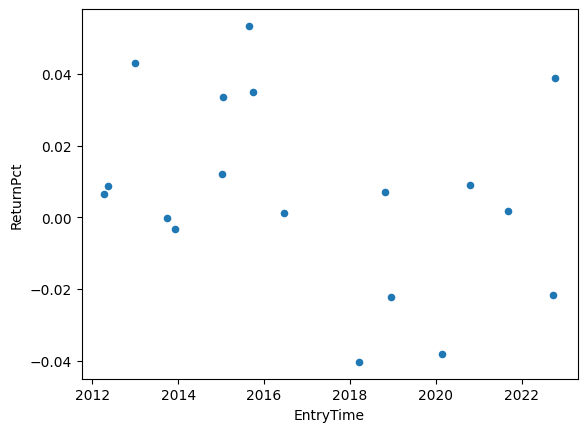

In [159]:
trades = stats["_trades"]
trades.plot.scatter(y="ReturnPct", x="EntryTime")

jetzt wird überprüft welche Tage für die Ein- und Ausstiege besser sein könnten.

In [160]:
stats, heatmap = bt.optimize(
    short_days=range(2, 6),
    barsheld=range(2, 6),
    lower_ibs=range(10, 40, 5),
    maximize="Profit Factor",  # "Equity Final [$]",
    max_tries=200,
    random_state=0,
    return_heatmap=True,
)

/Users/produktmanagement/Python/github/backtesting-trading-strategies/.venv/lib/python3.12/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


In [161]:
# heatmap
heatmap.sort_values().iloc[-5:]

short_days  barsheld  lower_ibs
4           5         10           3.037220
5           5         10           3.259964
                      15           3.381956
            4         15           5.140518
                      10           6.468479
Name: Profit Factor, dtype: float64

In [162]:
heatmap.groupby(["short_days", "lower_ibs", "barsheld"]).mean().unstack()

barsheld                     2         3         4         5
short_days lower_ibs                                        
2          10         0.902813  0.991606  1.071304  1.389126
           15         0.918322  1.091291  1.101948  1.312760
           20         0.847065  0.985816  1.183126  1.459226
           25         0.833249  0.949551  1.069493  1.385772
           30         0.850460  0.892964  1.031381  1.216076
           35         0.899739  0.933945  1.006154  1.328208
3          10         1.165115  1.222414  1.031244  1.419021
           15         1.177974  1.461911  1.230828  1.563431
           20         1.024195  1.080719  1.109101  1.461689
           25         1.011320  1.070208  1.047587  1.426071
           30         1.023763  1.075123  1.094626  1.513635
           35         0.979705  1.064037  1.026049  1.262832
4          10         1.217359  1.718567  1.653364  3.037220
           15         1.225879  1.557177  1.562109  2.548264
           20         1.020238  1.316268  1.228490  1.572662
           25         1.053310  1.362825  1.259988  1.525949
           30         1.113839  1.427212  1.169813  1.675264
           35         1.027469  1.284521  1.200279  1.420969
5          10         1.588429  2.530857  6.468479  3.259964
           15         1.632774  2.203336  5.140518  3.381956
           20         1.419683  1.647649  1.780496  1.900927
           25         1.499012  1.872712  2.318786  1.997614
           30         1.631480  2.118690  1.641551  1.568951
           35         1.757825  2.189244  2.311297  1.874283

In [163]:
stats

Start                     2012-01-03 00:00:00
End                       2024-04-17 00:00:00
Duration                   4488 days 00:00:00
Exposure Time [%]                    1.561483
Equity Final [$]                119242.979107
Equity Peak [$]                 119242.979107
Return [%]                          19.242979
Buy & Hold Return [%]              296.423531
Return (Ann.) [%]                    1.453212
Volatility (Ann.) [%]                3.471576
Sharpe Ratio                         0.418603
Sortino Ratio                         0.76517
Calmar Ratio                         0.286242
Max. Drawdown [%]                   -5.076863
Avg. Drawdown [%]                    -2.50462
Max. Drawdown Duration      960 days 00:00:00
Avg. Drawdown Duration      377 days 00:00:00
# Trades                                   12
Win Rate [%]                             75.0
Best Trade [%]                       6.200796
Worst Trade [%]                     -1.571772
Avg. Trade [%]                    

## The Winner is ...

In [164]:
stats["_strategy"]

<Strategy lower_days_reversal(short_days=5,barsheld=4,lower_ibs=10)>

In [165]:
# bt = Backtest(df["2012-01-01":], end_of_month, cash=100_000, commission=0.002)
stats = bt.run(short_days=5, barsheld=4, lower_ibs=15)
bt.plot(superimpose=False)  # , open_browser=False)

Row(id='27621', ...)

In [166]:
stats

Start                     2012-01-03 00:00:00
End                       2024-04-17 00:00:00
Duration                   4488 days 00:00:00
Exposure Time [%]                    1.951854
Equity Final [$]                118747.916987
Equity Peak [$]                 118747.916987
Return [%]                          18.747917
Buy & Hold Return [%]              296.423531
Return (Ann.) [%]                    1.418616
Volatility (Ann.) [%]                3.493042
Sharpe Ratio                         0.406126
Sortino Ratio                        0.736673
Calmar Ratio                         0.267094
Max. Drawdown [%]                   -5.311296
Avg. Drawdown [%]                   -2.676202
Max. Drawdown Duration      960 days 00:00:00
Avg. Drawdown Duration      483 days 00:00:00
# Trades                                   15
Win Rate [%]                        66.666667
Best Trade [%]                       6.200796
Worst Trade [%]                     -1.571772
Avg. Trade [%]                    

Die Win Rate beim Trading bezieht sich auf das Verhältnis der Anzahl der gewonnenen Trades zur Gesamtanzahl der Trades. 
Wenn jemand beispielsweise 70% seiner Trades gewinnt, beträgt seine Win Rate 70%.

In [167]:
stats["Win Rate [%]"]

66.66666666666666

Durchschnittlicher Gewinn in Prozent. 
Wie viel Gewinn oder Verlust wurden im Durchschnitt pro Trade erzielt.

In [168]:
stats["Avg. Trade [%]"]

1.1535044565326835

Der Profit-Faktor stellt die Verhältnisse zwischen Gewinnen und Verlusten dar.
Der Profit-Faktor wird berechnet, indem die Summe aller Profite (Gewinne) durch die Summe aller Verluste (einschließlich Gebühren und Kommissionen) für den gesamten Handelszeitraum geteilt wird.
Ein Profit-Faktor größer als 1 zeigt an, dass die Strategie profitabel ist. Je höher der Wert, desto besser.

Ein guter Profit-Faktor liegt normalerweise zwischen 1,75 und 41.
Ein Wert über 1,75 zeigt eine solide Strategie an, während Werte über 4 außergewöhnlich gut sind.

In [169]:
stats["Profit Factor"]

5.140518115414496

In [170]:
trades = stats["_trades"]

for index, row in trades.iterrows():
    start_range = stock[: row["EntryTime"]]
    trades.loc[index, "SignalTime"] = start_range.index.values[-2]

merged = pd.merge(
    trades,
    df[
        [
            "adx_10",
            "adx_direction",
            "rsi_3",
            "rsi_7",
            "rsi_10",
            "sma_20",
            "sma_50",
            "sma_100",
            "sma_200",
        ]
    ],
    left_on="SignalTime",
    right_index=True,
)
# merged["win"] = np.where(merged.PnL > 0, 1, -1)
# merged["win"] = np.where(merged.PnL > 0, 1, -1)

In [171]:
# merged.set_index('EntryTime')
monthly = pd.DataFrame(merged.groupby(merged.EntryTime.dt.month).ReturnPct.sum())
# global skip_month
skip_month = monthly[monthly["ReturnPct"] < 0.05].index.to_list()
pd.DataFrame(merged.groupby(merged.ExitTime.dt.month).ReturnPct.sum().round(4))

,ReturnPct
ExitTime,
1,0.0570
3,-0.0254
4,0.0071
5,0.0082
6,-0.0015
8,0.0620
9,-0.0046
10,0.0447
12,0.0286


<Axes: title={'center': 'Gewinner Trades'}>

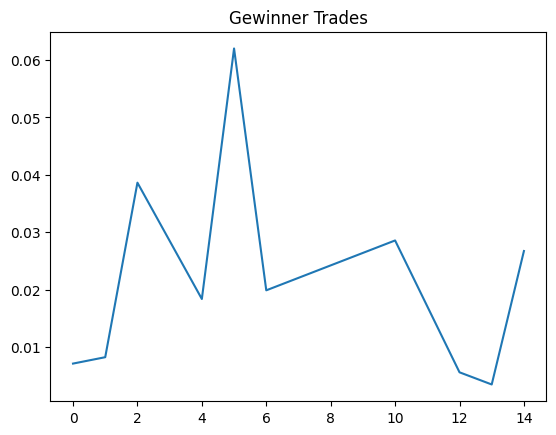

In [172]:
merged[merged.PnL > 0].ReturnPct.plot(title="Gewinner Trades")

<Axes: title={'center': 'Verlierer Trades'}>

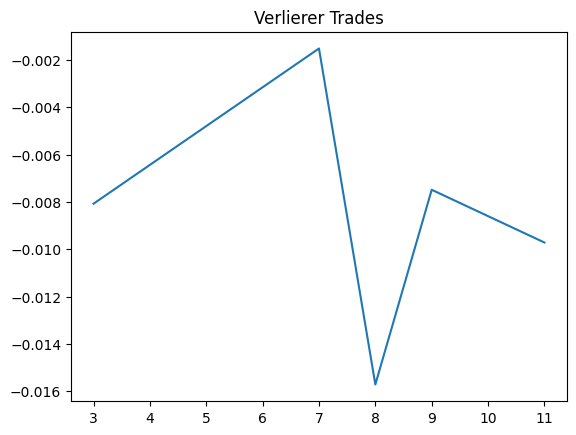

In [173]:
merged[merged.PnL < 0].ReturnPct.plot(title="Verlierer Trades")

In [174]:
df

,Open,High,Low,Close,Adj Close,Volume,vix,yield_5yr,rsi_3,rsi_7,...,adx_direction,adx_10,sma,sma_20,sma_50,sma_100,sma_200,sma_pct,lower,ibs
Date,,,,,,,,,,,,,,,,,,,,,
1993-01-29,43.968750,43.968750,43.750000,43.937500,24.763746,1003200,12.420000,5.570,NaN,NaN,...,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.857143
1993-02-01,43.968750,44.250000,43.968750,44.250000,24.939854,480500,12.330000,5.550,NaN,NaN,...,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.000000
1993-02-02,44.218750,44.375000,44.125000,44.343750,24.992706,201300,12.250000,5.630,100.0,NaN,...,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.875000
1993-02-03,44.406250,44.843750,44.375000,44.812500,25.256889,529400,12.120000,5.620,100.0,NaN,...,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.933333
1993-02-04,44.968750,45.093750,44.468750,45.000000,25.362598,531500,12.290000,5.530,100.0,NaN,...,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.850000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-11,515.679993,519.479980,512.080017,518.000000,518.000000,70099000,14.910000,4.623,54.0,51.0,...,1,20.357075,518.21,0.999595,1.017322,1.058872,1.115538,1.00,0,0.800002
2024-04-12,514.369995,515.820007,509.079987,510.850006,510.850006,92469100,17.309999,4.533,26.0,36.0,...,-1,20.947529,518.00,0.986197,1.002178,1.042977,1.099264,0.99,1,0.262613
2024-04-15,515.130005,515.299988,503.579987,504.450012,504.450012,92101400,19.230000,4.645,15.0,28.0,...,-1,22.939867,517.73,0.974350,0.989021,1.028776,1.084699,0.97,1,0.074234


In [175]:
stats

Start                     2012-01-03 00:00:00
End                       2024-04-17 00:00:00
Duration                   4488 days 00:00:00
Exposure Time [%]                    1.951854
Equity Final [$]                118747.916987
Equity Peak [$]                 118747.916987
Return [%]                          18.747917
Buy & Hold Return [%]              296.423531
Return (Ann.) [%]                    1.418616
Volatility (Ann.) [%]                3.493042
Sharpe Ratio                         0.406126
Sortino Ratio                        0.736673
Calmar Ratio                         0.267094
Max. Drawdown [%]                   -5.311296
Avg. Drawdown [%]                   -2.676202
Max. Drawdown Duration      960 days 00:00:00
Avg. Drawdown Duration      483 days 00:00:00
# Trades                                   15
Win Rate [%]                        66.666667
Best Trade [%]                       6.200796
Worst Trade [%]                     -1.571772
Avg. Trade [%]                    

In [176]:
pd.DataFrame(merged.groupby(merged.ExitTime.dt.month).ReturnPct.sum().round(4))

,ReturnPct
ExitTime,
1,0.0570
3,-0.0254
4,0.0071
5,0.0082
6,-0.0015
8,0.0620
9,-0.0046
10,0.0447
12,0.0286


In [177]:
pd.DataFrame(merged.groupby(merged.ExitTime.dt.year).PnL.sum().round(1))

,PnL
ExitTime,
2012,1538.8
2013,3067.7
2015,10762.6
2016,-174.8
2018,552.7
2020,-482.3
2021,399.7
2022,3083.6


In [178]:
equity = stats["_equity_curve"]
equity.groupby(equity.index.year).Equity.last().round(1)

2012    103057.0
2013    104606.4
2014    104606.4
2015    115369.0
2016    115194.2
2017    115194.2
2018    115746.9
2019    115746.9
2020    115264.6
2021    115664.3
2022    118747.9
2023    118747.9
2024    118747.9
Name: Equity, dtype: float64